![ga4](https://www.google-analytics.com/collect?v=2&tid=G-6VDTYWLKX6&cid=1&en=page_view&sid=1&dl=statmike%2Fvertex-ai-mlops%2FApplied+Forecasting&dt=BQML+Regression+Based+Forecasting.ipynb)

# BQML Regression Based Forecasting
# (IN DEVELOPMENT)

TODO:
- [ ] four examples:
    - [X] 1 - time features - Linear Regression
    - [X] 2 - add lags features - Linear Regression
    - [ ] 3 - use leads for multi-step model - Linear Regression
    - [ ] 4 - use leas for multi-step model - Boosted Tree
- [ ] writeup notes

Time series based forecasting methods are covered in this series [Applied Forecasting](./readme.md) series. Most of the methods used in this series are time series focused methods trend modeling with ARIMA, additive models like Prophet, and specially designed neural networks.  

This notebook will walk through the concepts of using regression approach to time series modeling. I like to think of this a prediction based approaches to forecasting based on leads (a view into future) and lags (a view into the past).  

---
## Setup

inputs:

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [17]:
REGION = 'us-central1'
EXPERIMENT = 'regression'
SERIES = 'applied-forecasting'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = 'forecasting-1_prepped'

viz_limit = 12

packages:

In [3]:
from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

clients:

In [5]:
bq = bigquery.Client(project = PROJECT_ID)

---
## Review Time Series

In [6]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'

Retrieve Key Dates for splits:

In [7]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

,start_date,val_start,test_start,end_date
0,2013-07-01,2016-09-03,2016-09-17,2016-09-30


Retrieve raw data:

In [8]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, splits, {TARGET_COLUMN}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

### Plot Time Series

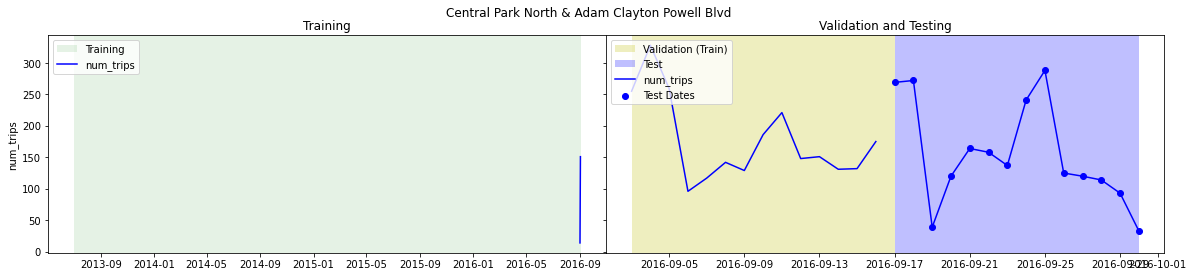

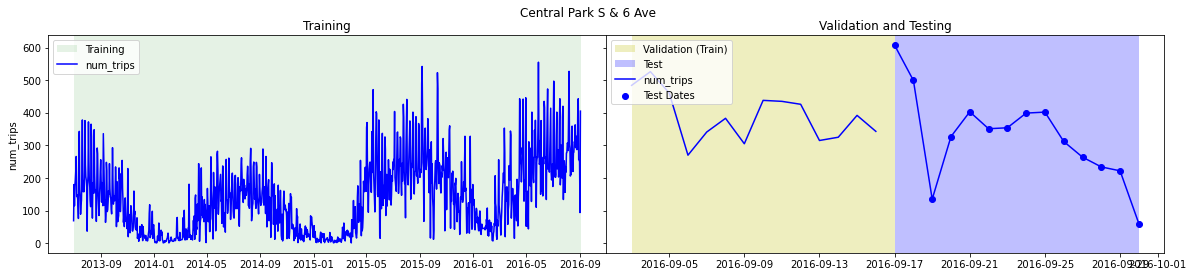

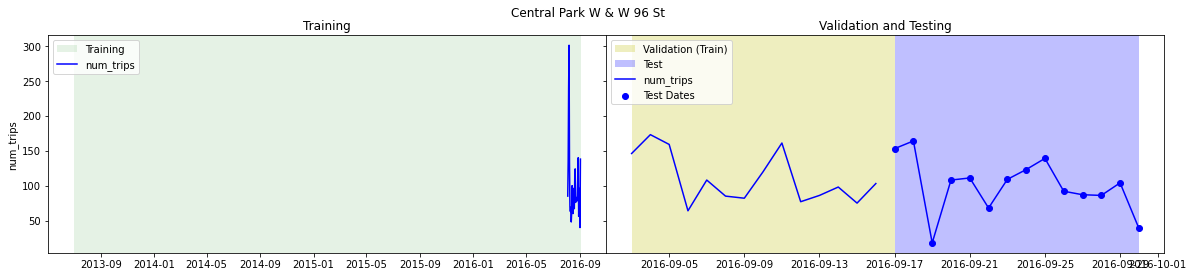

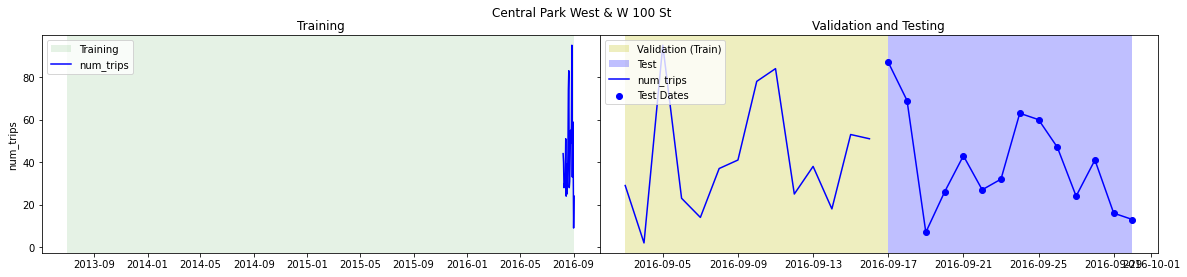

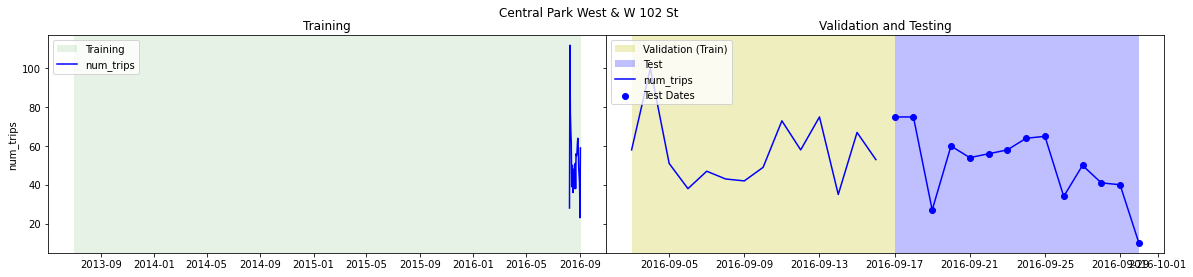

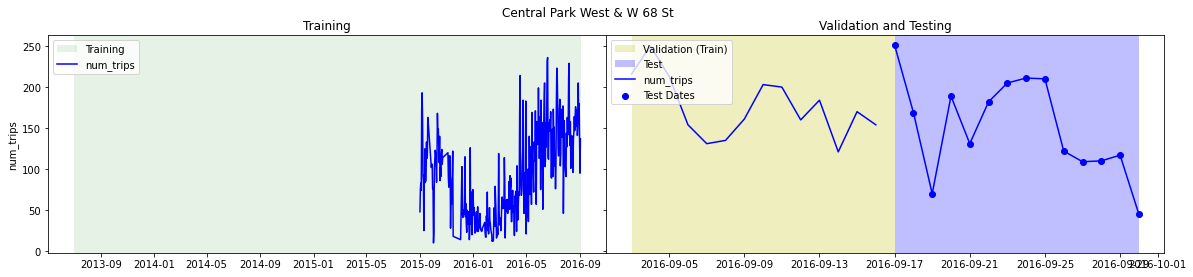

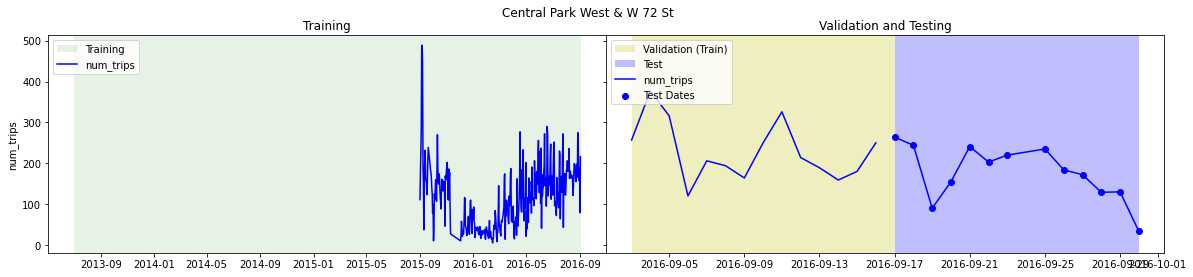

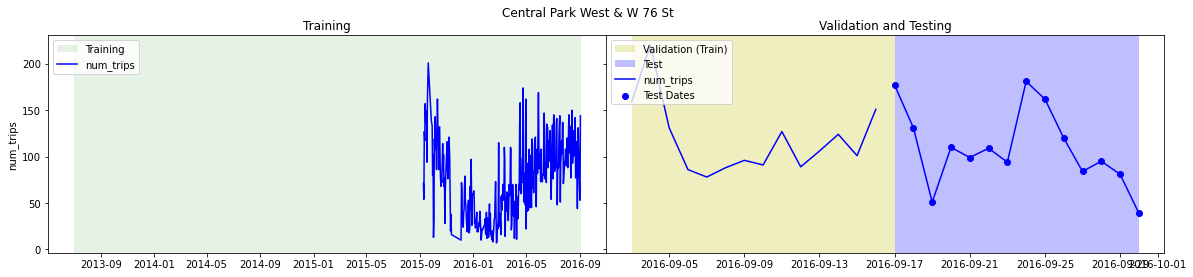

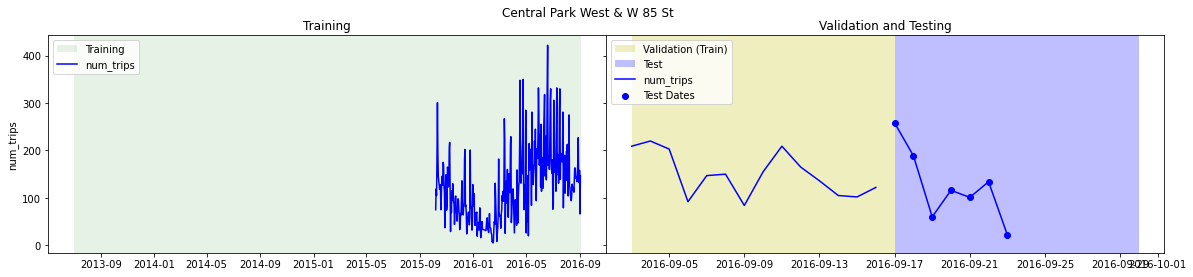

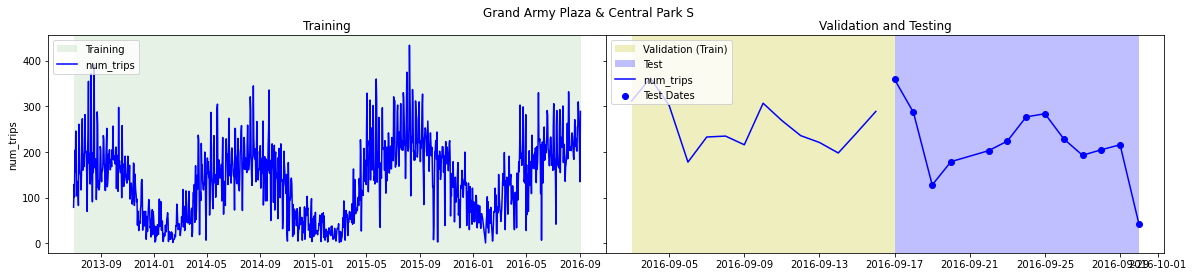

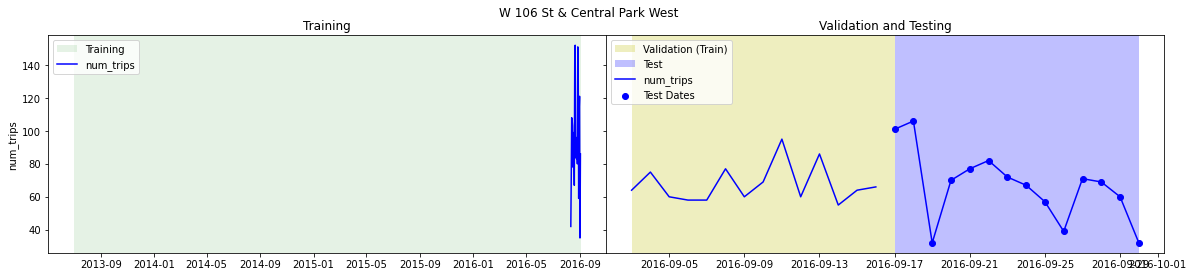

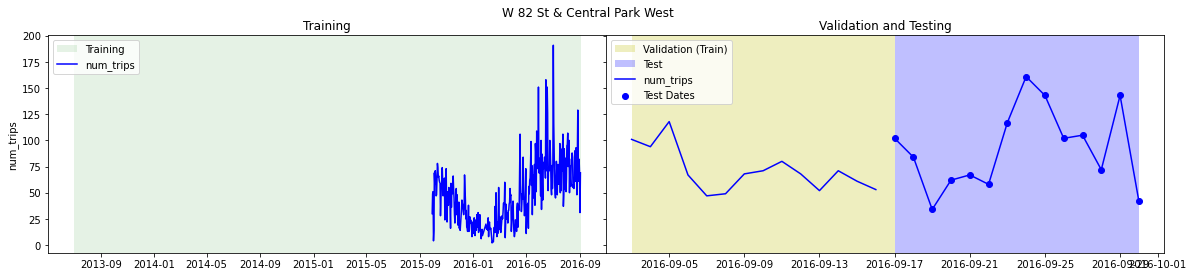

In [9]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')
        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st)

        # display result
        plt.show()

---
## Linear Regression - Example 1
- Using Time Features: Week, Month, Year, Day, ...

Regression methods don't know about time/date based data types.  To get started, lets first decompose the `TIME_COLUMN` into parts like year, month, day, day of week and model with a linear regression to find the optimal weights of these components.

In [60]:
EX2_CTE = f"""
WITH TIMEDATA AS (
    SELECT
        {TARGET_COLUMN},
        {SERIES_COLUMN},
        splits,
        
        # TIME FEATURES
        EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
        EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
        EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
        EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
        EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
        CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,
        
        # LAGs
        
        
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
)
"""

In [62]:
BQ_MODEL = f"{BQ_TABLE}_Regression_Example_1"
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['{TARGET_COLUMN}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
    {EX1_CTE}
    SELECT
        * EXCEPT(splits),
        CASE
            WHEN splits = 'TRAIN' THEN FALSE
            ELSE TRUE
        END AS custom_splits
    FROM TIMEDATA
    WHERE splits in ('TRAIN', 'VALIDATE')
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 16.336


In [63]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-1_prepped_Regression_Example_1


In [64]:
query = f"""
SELECT *
FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
weights = bq.query(query = query).to_dataframe()
weights

,processed_input,weight,category_weights
0,start_station_name,NaN,[{'category': 'Central Park North & Adam Clayt...
1,Year,42.671947,[]
2,Month,988.641558,[]
3,Day_of_Month,32.555400,[]
4,Day_of_Year,-32.181374,[]
5,Day_of_Week,-0.614223,[]
6,Weekend,45.698300,[]
7,__INTERCEPT__,-70106.722965,[]


In [65]:
weights['category_weights'].iloc[0]

array([{'category': 'Central Park North & Adam Clayton Powell Blvd', 'weight': -16880.124031007752},
       {'category': 'Central Park West & W 76 St', 'weight': -16898.037950101312},
       {'category': 'Central Park West & W 85 St', 'weight': -16848.96249740301},
       {'category': 'W 82 St & Central Park West', 'weight': -16927.453264589058},
       {'category': 'W 106 St & Central Park West', 'weight': -16894.85460719642},
       {'category': 'Central Park West & W 68 St', 'weight': -16880.800948690696},
       {'category': 'Central Park S & 6 Ave', 'weight': -16799.563743066432},
       {'category': 'Grand Army Plaza & Central Park S', 'weight': -16803.677230849167},
       {'category': 'Central Park W & W 96 St', 'weight': -16890.73791392327},
       {'category': 'Central Park West & W 102 St', 'weight': -16936.55743994627},
       {'category': 'Central Park West & W 72 St', 'weight': -16856.5863539997},
       {'category': 'Central Park West & W 100 St', 'weight': -16946.211286

In [66]:
query = f"""
{EX1_CTE}
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM TIMEDATA WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM TIMEDATA WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM TIMEDATA WHERE SPLITS='TRAIN'))
"""
bq.query(query = query).to_dataframe()

,SPLIT,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,VALIDATE,60.772229,7715.211259,0.312313,35.577067,0.319344,0.577856
1,TRAIN,52.547008,4819.465819,0.676781,41.346673,0.359895,0.359895
2,TEST,50.051585,5615.421813,0.272105,30.539519,0.449021,0.546828


In [68]:
query = f"""
{EX1_CTE}
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM TIMEDATA
    )
  )
ORDER BY Year, Month, Day_of_Month
"""
pred = bq.query(query = query).to_dataframe()

In [69]:
pred

,start_station_name,starttime,predicted
0,Central Park S & 6 Ave,2013-07-01,87.150676
1,Grand Army Plaza & Central Park S,2013-07-01,83.037188
2,Grand Army Plaza & Central Park S,2013-07-02,82.796991
3,Central Park S & 6 Ave,2013-07-02,86.910479
4,Grand Army Plaza & Central Park S,2013-07-03,82.556794
...,...,...,...
4377,Central Park West & W 76 St,2016-09-30,74.938701
4378,W 82 St & Central Park West,2016-09-30,45.523387
4379,Grand Army Plaza & Central Park S,2016-09-30,169.299420
4380,Central Park West & W 68 St,2016-09-30,92.175703


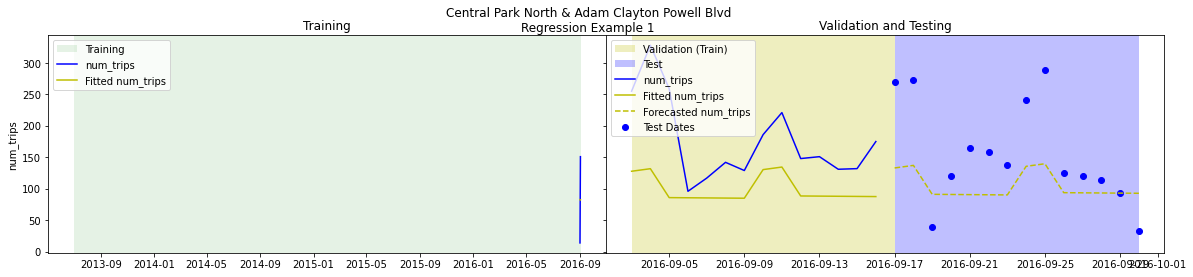

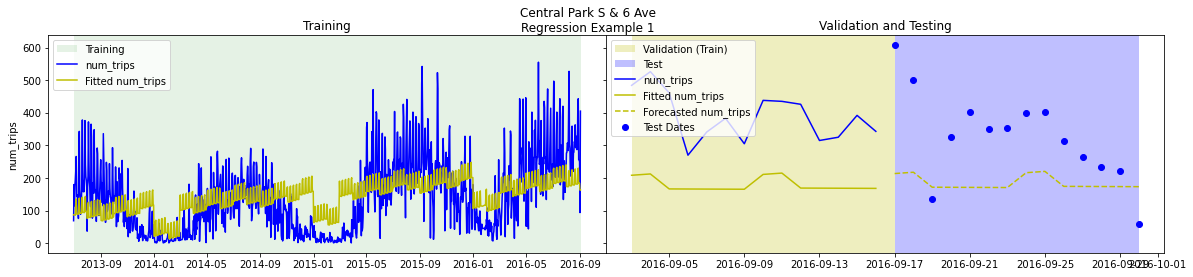

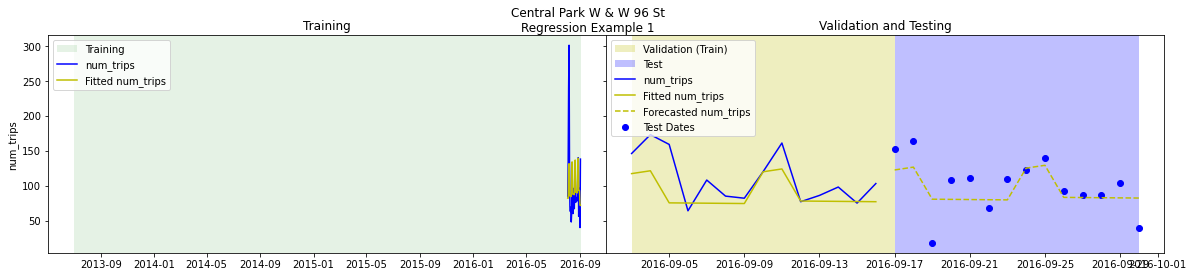

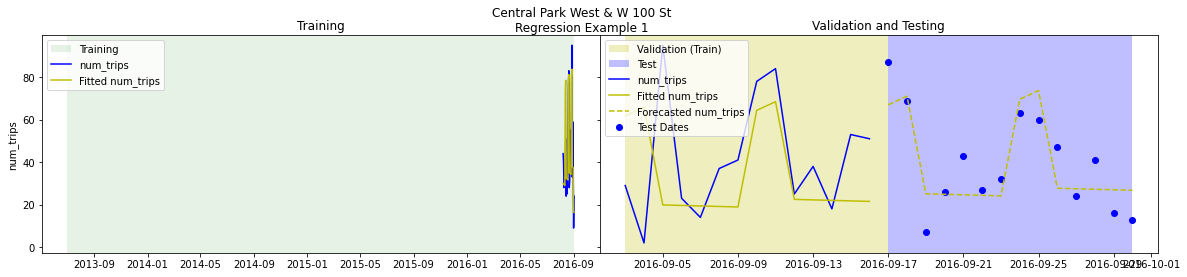

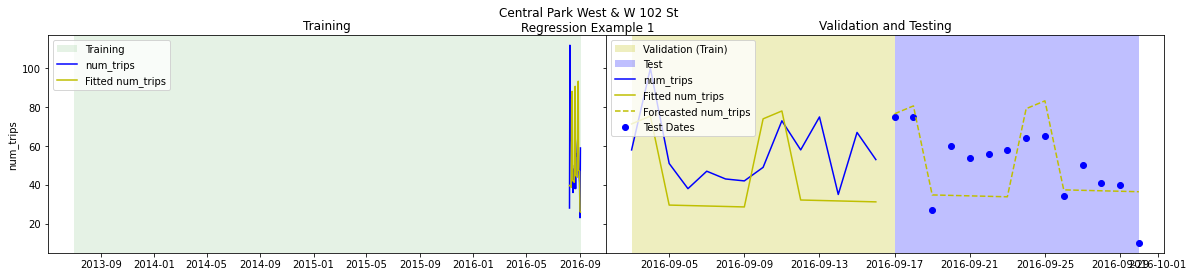

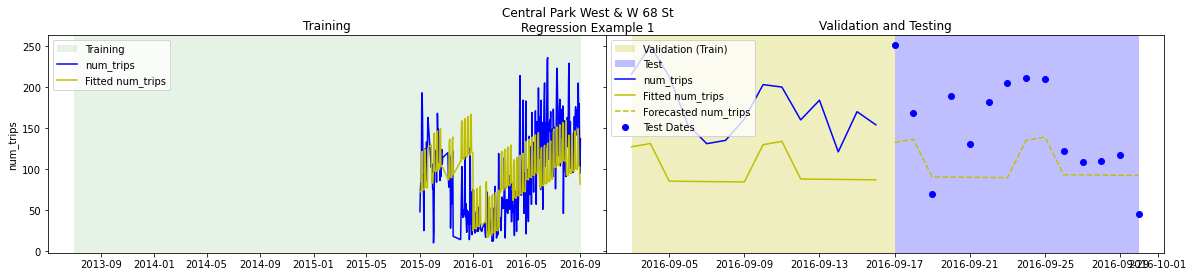

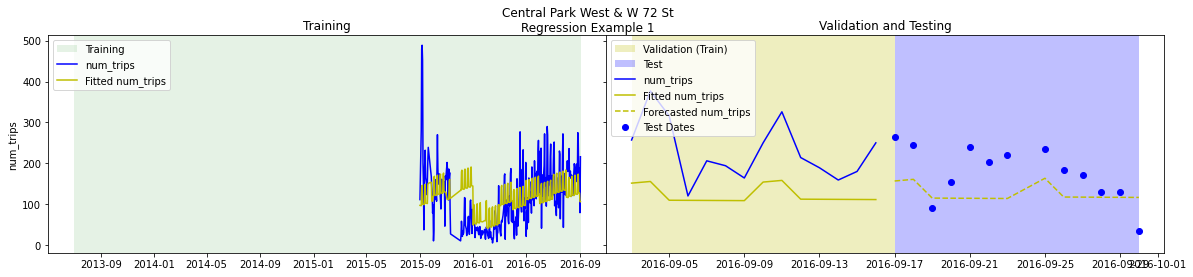

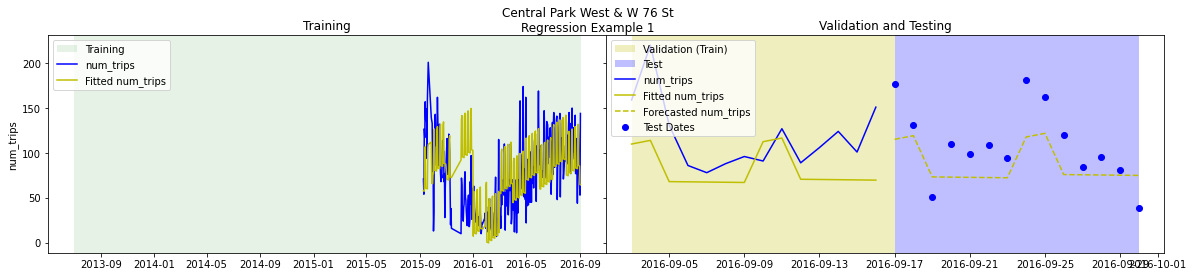

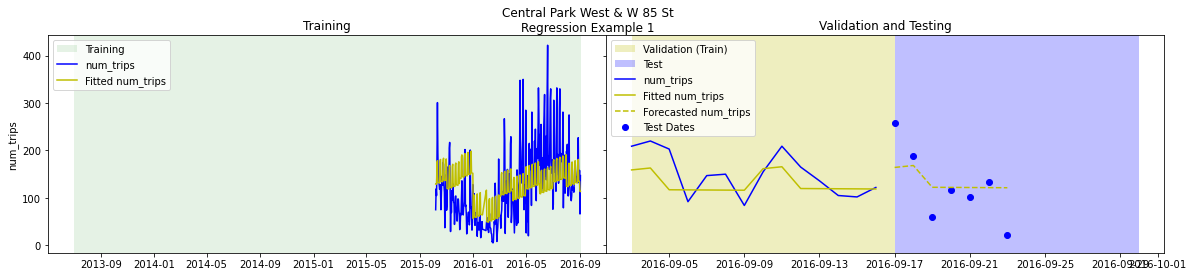

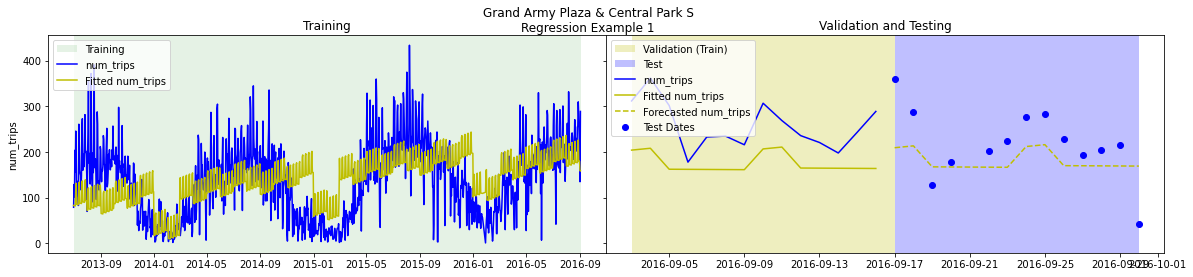

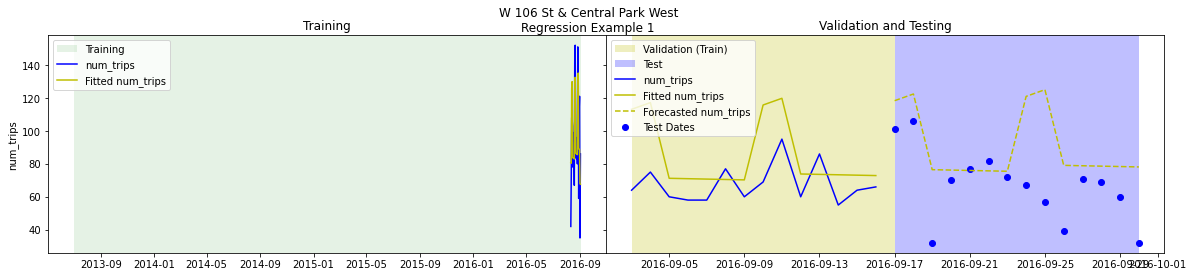

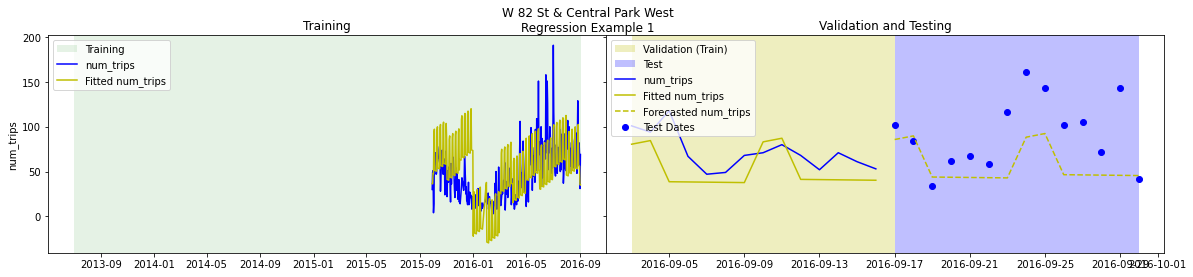

In [70]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        fit_traindf = pred[(pred[SERIES_COLUMN] == st) & (pred[TIME_COLUMN] < keyDates['val_start'][0])]
        fit_valdf = pred[(pred[SERIES_COLUMN] == st) & (pred[TIME_COLUMN] >= keyDates['val_start'][0]) & (pred[TIME_COLUMN] < keyDates['test_start'][0])]
        fit_testdf = pred[(pred[SERIES_COLUMN] == st) & (pred[TIME_COLUMN] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        #axes[1].fill_between(fit_testdf[TIME_COLUMN], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        axes[0].plot(fit_traindf[TIME_COLUMN], fit_traindf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_valdf[TIME_COLUMN], fit_valdf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['predicted'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nRegression Example 1")

        # display result
        plt.show()

---
## Linear Regression - Example 2
- Using Time Features: Week, Month, Year, Day, ...
- Using Lags


In [71]:
EX2_CTE = f"""
WITH TIMEDATA AS (
    SELECT
        {TARGET_COLUMN},
        {SERIES_COLUMN},
        splits,
        
        # TIME FEATURES
        EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
        EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
        EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
        EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
        EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
        CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,
        
        # LAGs
        LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
        LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
        LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
        LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
        LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year
        
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
)
"""

In [72]:
BQ_MODEL = f"{BQ_TABLE}_Regression_Example_2"
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['{TARGET_COLUMN}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
    {EX2_CTE}
    SELECT
        * EXCEPT(splits),
        CASE
            WHEN splits = 'TRAIN' THEN FALSE
            ELSE TRUE
        END AS custom_splits
    FROM TIMEDATA
    WHERE splits in ('TRAIN', 'VALIDATE')
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 15.622


In [73]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')

Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=statmike-mlops-349915&ws=!1m5!1m4!5m3!1sstatmike-mlops-349915!2sapplied_forecasting!3sforecasting-1_prepped_Regression_Example_2


In [76]:
query = f"""
SELECT *
FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
weights = bq.query(query = query).to_dataframe()
weights

,processed_input,weight,category_weights
0,start_station_name,NaN,"[{'category': 'Central Park West & W 72 St', '..."
1,Year,8.720551,[]
2,Month,314.911542,[]
3,Day_of_Month,10.473897,[]
4,Day_of_Year,-10.331099,[]
5,Day_of_Week,3.230271,[]
6,Weekend,23.500901,[]
7,lag_1day,0.446639,[]
8,lag_1week,0.222376,[]
9,lag_1month,0.161758,[]


In [78]:
weights['category_weights'].iloc[0]

array([{'category': 'Central Park West & W 72 St', 'weight': -4897.3038000454735},
       {'category': 'Central Park West & W 76 St', 'weight': -4906.279920286685},
       {'category': 'Central Park North & Adam Clayton Powell Blvd', 'weight': -4900.943396226415},
       {'category': 'W 82 St & Central Park West', 'weight': -4911.910269122222},
       {'category': 'Central Park W & W 96 St', 'weight': -4904.739816876672},
       {'category': 'Central Park West & W 102 St', 'weight': -4923.627566367521},
       {'category': 'Central Park West & W 68 St', 'weight': -4902.332907012081},
       {'category': 'W 106 St & Central Park West', 'weight': -4907.219041581968},
       {'category': 'Central Park S & 6 Ave', 'weight': -4886.88718722635},
       {'category': 'Central Park West & W 85 St', 'weight': -4896.718977211484},
       {'category': 'Central Park West & W 100 St', 'weight': -4927.612256958211},
       {'category': 'Grand Army Plaza & Central Park S', 'weight': -4888.95996862562}

### Prediction with Lags

It is tricky. In using the 'TEST' split for predictions, each day has the actual data for lags.  In a real forecasting horizon you will not know these values.  For this reason you can only fully predict the first day of the horizon with a one step model like this one. To predict further out you need to recursively feed each forecast back into the same model as a lag for the next step.  This does accumulate errors though.  An alternative to this try a multi-step moel - see Example 3.

The example here does a recursive prediction.

In [90]:
test_start = keyDates['test_start'].iloc[0]
test_start.year, test_start.month, test_start.day

(2016, 9, 17)

In [117]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` AS
{EX2_CTE}
SELECT * EXCEPT(lag_1day, lag_1week),
    CASE
        WHEN DATE(year, month, day_of_month)> DATE({test_start.year},{test_start.month},{test_start.day}) THEN NULL
        ELSE lag_1day
    END AS lag_1day,
    CASE
        WHEN DATE(year, month, day_of_month)> DATE_ADD(DATE({test_start.year},{test_start.month},{test_start.day}), INTERVAL 7 DAY) THEN NULL
        ELSE lag_1week
    END AS lag_1week,
    ROW_NUMBER() OVER(PARTITION BY {SERIES_COLUMN} ORDER BY year, month, day_of_month) as horizon_day
FROM TIMEDATA
WHERE splits = 'TEST'
ORDER BY {SERIES_COLUMN}, year, month, day_of_month
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 2.067


Recursively predict the values for the TEST Data and fill in lags:
- [QUALIFY clause](https://cloud.google.com/bigquery/docs/reference/standard-sql/query-syntax#qualify_clause)

THERE MUST BE A BETTER WAY TO DO THE FOLLOWING
- I tried Recursive CTE but need to reference the base twice (1Day and 1Week) which fails

In [139]:
# PREDICTIONS FOR FIRST DAY OF HORIZON
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` AS
    SELECT *
    FROM ML.PREDICT (
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
        (
            SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
            WHERE horizon_day = 1
        )
    )
"""
job = bq.query(query = query)
job.result()

query = f"""
SELECT column_name
FROM `{BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{BQ_MODEL}_TEST_DATA_RECURSIVE'
"""
columns_in_order = ', '.join(list(bq.query(query).to_dataframe()['column_name']))

# PREDICTION FOR SECOND DAY OF HORIZON TO LAST DAY OF HORIZON
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for day in range(2, horizon_length+1):
    query = f"""
    INSERT INTO `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
        WITH
            TODAY AS (
                SELECT * EXCEPT(lag_1day, lag_1week)
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
                WHERE horizon_day = {day}
            ),
            LAG_DAY AS (
                SELECT {SERIES_COLUMN}, CAST(FLOOR(predicted_{TARGET_COLUMN}) AS INT64) as lag_1day 
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
                WHERE horizon_day = {day-1} 
            ),
            LAG_WEEK AS (
                SELECT {SERIES_COLUMN}, CAST(FLOOR(predicted_{TARGET_COLUMN}) AS INT64) as lag_1week 
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
                WHERE horizon_day = {day-7} 
            ),
            CURRENT_DAY AS (
                SELECT * FROM
                    TODAY
                    JOIN LAG_DAY USING ({SERIES_COLUMN})
                    LEFT OUTER JOIN LAG_WEEK USING ({SERIES_COLUMN})
            )
        SELECT {columns_in_order}
        FROM  ML.PREDICT (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
            (SELECT * FROM CURRENT_DAY)
        )
    """
    job = bq.query(query = query)
    job.result()
    

### Evaluation Metrics

The evaluation result show three ways of looking at the test data range:
- `TEST - LEAKED` For days of the test horizon past day 1 the lag values are leaked from known data which likely over estimates the models performance
- `TEST - TRUNCATED` For days of the test horizon past day 1 the lag values remain null if they are from the test horizon
- `TEST - RECURSIVE` For days of the test horizon past day 1 the lag values are recursively retrieved from prior test days predictions.

In [142]:
query = f"""
{EX2_CTE}
# uses recursive predictions to get lags for next step in horizon
SELECT 'TEST - RECURSIVE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` WHERE SPLITS='TEST'))
UNION ALL
# Truncated does not have lags filled in our of range
SELECT 'TEST - TRUNCATED' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` WHERE SPLITS='TEST'))
UNION ALL
# wrong has lags filled in from actual data but not practical for measuring forecasting horizon - leakage
SELECT 'TEST - LEAKED' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM TIMEDATA WHERE SPLITS='TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM TIMEDATA WHERE SPLITS='VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM TIMEDATA WHERE SPLITS='TRAIN'))
ORDER BY SPLIT
"""
bq.query(query = query).to_dataframe()

,SPLIT,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,TEST - LEAKED,35.983011,2990.477891,0.343685,23.019781,0.706577,0.709698
1,TEST - RECURSIVE,43.842746,3651.434226,0.374428,32.035080,0.641725,0.704553
2,TEST - TRUNCATED,46.613177,4211.675650,0.294681,30.272659,0.586755,0.616462
3,TRAIN,33.154525,2217.965437,0.354549,23.072566,0.705417,0.705417
4,VALIDATE,33.653193,2010.230326,0.254856,26.277667,0.822652,0.863361


In [146]:
query = f"""
{EX2_CTE}
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT * FROM TIMEDATA WHERE splits in ('TRAIN', 'VALIDATE')
    UNION ALL
    SELECT * EXCEPT(horizon_day, predicted_{TARGET_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` WHERE SPLITS='TEST' 
    )
  )
ORDER BY Year, Month, Day_of_Month
"""
pred = bq.query(query = query).to_dataframe()

In [147]:
pred

,start_station_name,starttime,predicted
0,Central Park S & 6 Ave,2013-07-01,103.262331
1,Grand Army Plaza & Central Park S,2013-07-01,101.189549
2,Central Park S & 6 Ave,2013-07-02,84.782590
3,Grand Army Plaza & Central Park S,2013-07-02,87.176194
4,Central Park S & 6 Ave,2013-07-03,137.732537
...,...,...,...
4377,Central Park W & W 96 St,2016-09-30,113.064496
4378,Central Park West & W 76 St,2016-09-30,116.201872
4379,W 82 St & Central Park West,2016-09-30,90.183524
4380,Central Park West & W 68 St,2016-09-30,129.558231


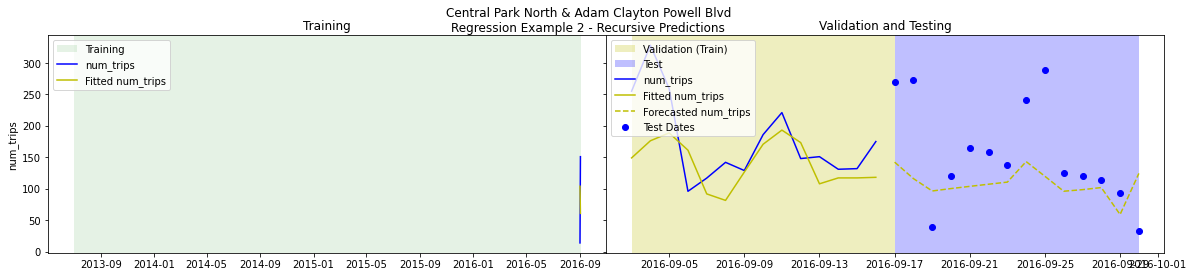

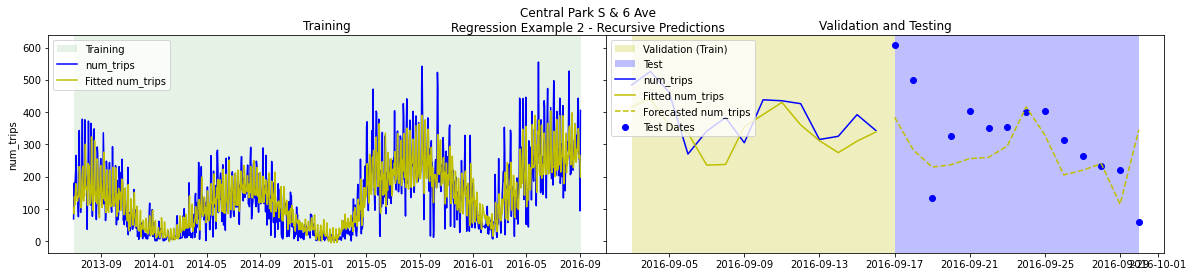

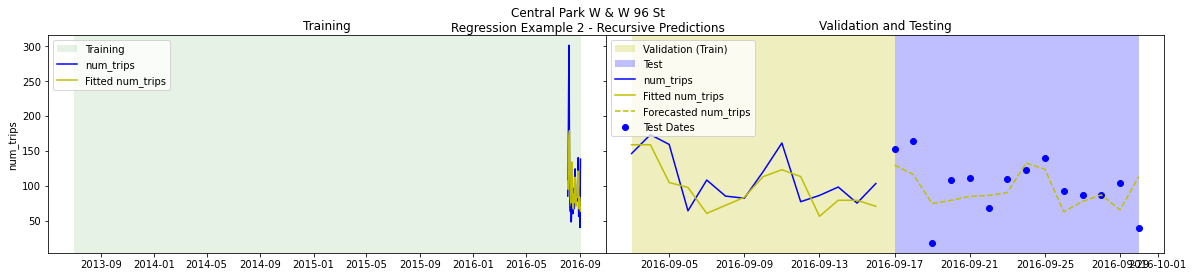

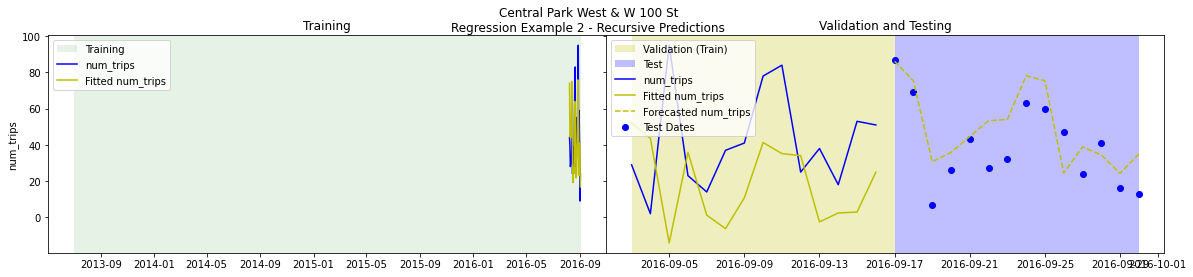

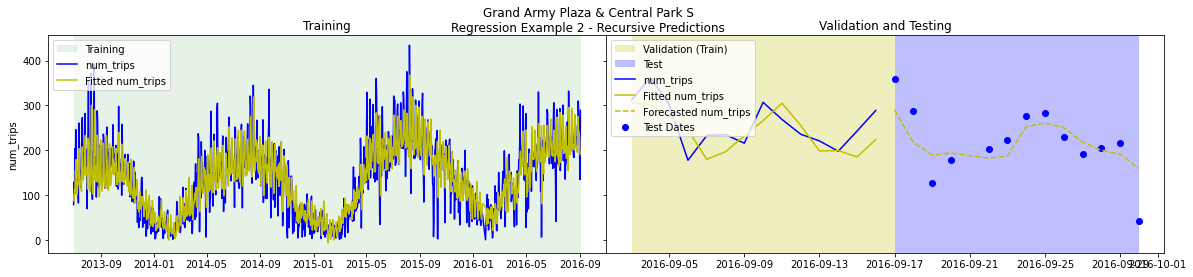

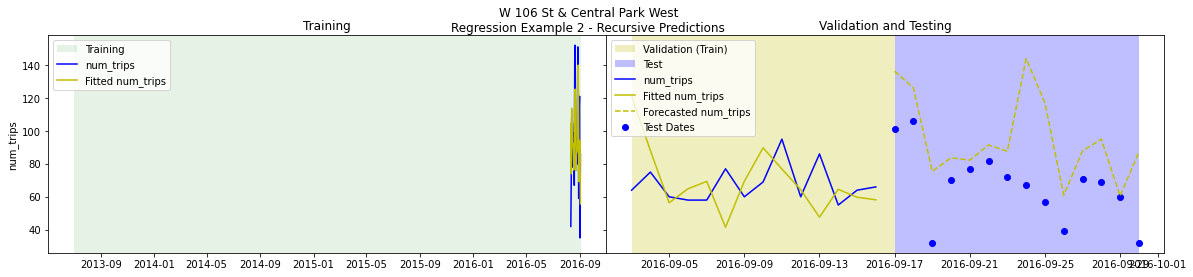

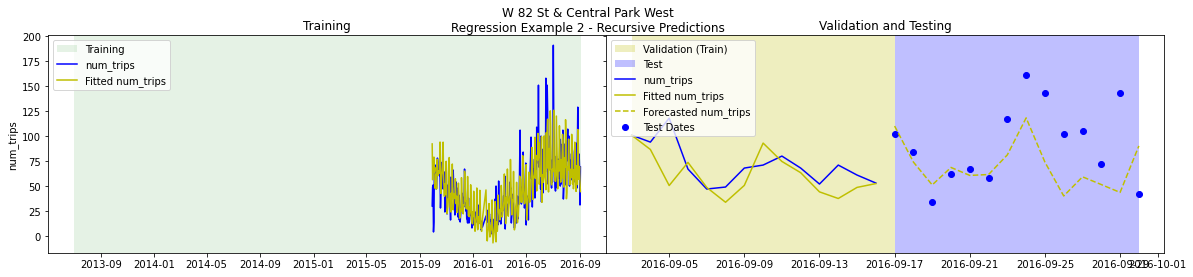

In [149]:
series = rawSeries[SERIES_COLUMN].unique().tolist()
for s, st in enumerate(series):
    if s <= viz_limit:
        # setup plot area
        fig, axes = plt.subplots(1, 2, figsize=(20, 4), sharex=False, sharey=True)
        fig.subplots_adjust(wspace=0)

        # data
        traindf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TRAIN')]
        valdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'VALIDATE')]
        testdf = rawSeries[(rawSeries[SERIES_COLUMN] == st) & (rawSeries['splits'] == 'TEST')]
        fit_traindf = pred[(pred[SERIES_COLUMN] == st) & (pred[TIME_COLUMN] < keyDates['val_start'][0])]
        fit_valdf = pred[(pred[SERIES_COLUMN] == st) & (pred[TIME_COLUMN] >= keyDates['val_start'][0]) & (pred[TIME_COLUMN] < keyDates['test_start'][0])]
        fit_testdf = pred[(pred[SERIES_COLUMN] == st) & (pred[TIME_COLUMN] >= keyDates['test_start'][0])]

        # regions
        axes[0].axvspan(keyDates['start_date'][0], keyDates['val_start'][0], facecolor='g', alpha = 0.1, label = 'Training')
        axes[1].axvspan(keyDates['val_start'][0], keyDates['test_start'][0], facecolor='y', alpha = 0.25, label = 'Validation (Train)')
        axes[1].axvspan(keyDates['test_start'][0], keyDates['end_date'][0], facecolor='b', alpha = 0.25, label = 'Test')
        #axes[1].fill_between(fit_testdf[TIME_COLUMN], fit_testdf['prediction_interval_lower_bound'], fit_testdf['prediction_interval_upper_bound'], color = 'g', alpha = 0.9, label = '95% Prediction Interval')

        # lines and dots
        axes[0].plot(traindf[TIME_COLUMN], traindf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        axes[1].plot(valdf[TIME_COLUMN], valdf[TARGET_COLUMN], color = 'b', label = f'{TARGET_COLUMN}')
        #axes[1].plot(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b')

        axes[0].plot(fit_traindf[TIME_COLUMN], fit_traindf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_valdf[TIME_COLUMN], fit_valdf['predicted'], color = 'y', label = f'Fitted {TARGET_COLUMN}')
        axes[1].plot(fit_testdf[TIME_COLUMN], fit_testdf['predicted'], color = 'y', label = f'Forecasted {TARGET_COLUMN}', linestyle='dashed')

        axes[1].scatter(testdf[TIME_COLUMN], testdf[TARGET_COLUMN], color = 'b', label = 'Test Dates')

        # labels
        axes[0].set_ylabel(TARGET_COLUMN)
        axes[0].set_title('Training')
        axes[1].set_title('Validation and Testing')
        axes[1].legend(loc = 'upper left')
        axes[0].legend(loc = 'upper left')
        plt.suptitle(st + f"\nRegression Example 2 - Recursive Predictions")

        # display result
        plt.show()

---
## Linear Regression - Example 3
- Using Time Features: Week, Month, Year, Day, ...
- Using Lags
- Using Leads for Multi-step model

---
## Boosted Tree Regressor - Example 4
- Using Time Features: Week, Month, Year, Day, ...
- Using Lags
- Using Leads for Multi-step model